In [2]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym
from stable_baselines3.common.monitor import Monitor
import os, json, datetime
from pathlib import Path
from IPython import display
from functools import lru_cache
import pickle

0 {'prob': 1}


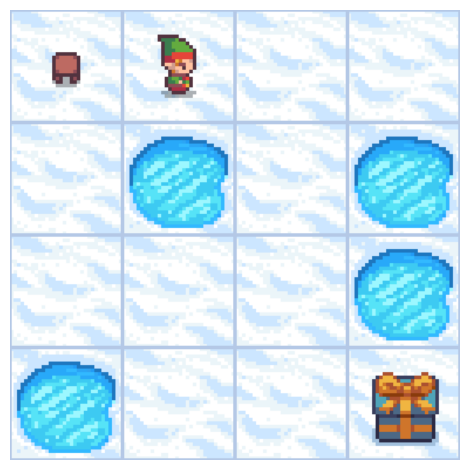

In [18]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")

# reset the environment to get the first observation
done = False
observation, info = env.reset()

print(observation, info)

img = env.render()
# plt.imshow(img)

# sample a random action from all valid actions
# action = env.action_space.sample()
action=2


# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

plt.figure()
img = env.render()
plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.savefig("./report/figures/frozen_lake_overview.png", bbox_inches="tight")


In [4]:
def plot_stats(env_agent_pairs, rolling_length = 500):
    fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
    axs[0].set_title("Episode rewards")

    for env, agent in env_agent_pairs:
        # compute and assign a rolling average of the data to provide a smoother graph
        reward_moving_average = (
            np.convolve(
                np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
            )
            / rolling_length
        )
        axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
        axs[1].set_title("Episode lengths")
        length_moving_average = (
            np.convolve(
                np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
            )
            / rolling_length
        )
        axs[1].plot(range(len(length_moving_average)), length_moving_average)
        axs[2].set_title("Training Error")
        training_error_moving_average = (
            np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
            / rolling_length
        )
        axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

    plt.tight_layout()


In [19]:
class IRLAgent:
    def __init__(
        self,
        env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(self.env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

        self.update_count = 0

    def get_action(self, obs: tuple[int, int, bool], epsilon=None) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        if epsilon is None:
            epsilon = self.epsilon

        # with probability epsilon return a random action to explore the environment
        if np.random.random() < epsilon:
            return self.env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def temporal_difference(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ) -> float:
        """Computes the temporal difference error."""
        # max of Q(s', a) over all possible actions a
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        return (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        temporal_difference = self.temporal_difference(
            obs, action, reward, terminated, next_obs
        )
        self.q_values[obs][action] += self.lr * temporal_difference
        self.training_error.append(temporal_difference)

    def simple_update(self, obs: tuple[int, int, bool], action: int, reward: float):
        self.q_values[obs][action] += self.lr * (reward - self.q_values[obs][action])

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


@lru_cache(maxsize=1000)
def human_feedback_cached_implicit(
    current_col, current_row, next_col, next_row, run_id
):
    a = input("Was the agent's action correct? (y/n)")
    return a

@lru_cache(maxsize=1000)
def human_feedback_cached_explicit(current_col, current_row, run_id):
    a = input("What should the agent have done? (w/a/s/d)")
    return a

def human_feedback_cached(
    current_col, current_row, next_col, next_row, run_id, method="None"
):
    reward = 0
    a = ""

    if (
        method in ["explicit", "implicit"]
        and current_col == next_col
        and current_row == next_row
    ):
        return reward, a

    if method == "implicit":
        a = human_feedback_cached_implicit(
            current_col, current_row, next_col, next_row, run_id
        )
        if a == "y":
            reward += 1
        elif a == "q":
            raise
    elif method == "explicit":
        dx = next_col - current_col
        dy = next_row - current_row
        if [dx, dy] == [0, -1]:
            last_action = "w"
        elif [dx, dy] == [-1, 0]:
            last_action = "a"
        elif [dx, dy] == [0, 1]:
            last_action = "s"
        elif [dx, dy] == [1, 0]:
            last_action = "d"

        plt.text(100, 100, f"Last action: {last_action}")

        a = human_feedback_cached_explicit(current_col, current_row, run_id)
        if a == last_action:
            reward += 1
        elif a == "q":
            raise

    return reward, a

human_intuition_cache = []
def human_intuition(env, obs, next_obs, run_id, render=True, method="None"):
    img = env.render()

    current_col = obs % 4
    current_row = obs // 4

    next_col = next_obs % 4
    next_row = next_obs // 4

    grid_height = img.shape[1] / 4
    grid_width = img.shape[0] / 4

    render = render and method in ["explicit", "implicit"]

    # test if the same call has been made before
    key = f"{current_col}{current_row}{next_col}{next_row}{run_id}{method}"
    global human_intuition_cache
    if key not in human_intuition_cache:
        human_intuition_cache.append(key)
        render = True
    else:
        render = False

    if render:
        display.clear_output(wait=True)
        print(f"Current state: {current_row}, {current_col}")
        print(f"Next state: {next_row}, {next_col}")
        plt.imshow(img)
        plt.arrow(
            current_col * grid_width + grid_width / 2,
            current_row * grid_height + grid_height / 2,
            (next_col - current_col) * grid_width,
            (next_row - current_row) * grid_height,
            head_width=10,
            head_length=10,
            fc="r",
            ec="r",
        )
        dx = next_col - current_col
        dy = next_row - current_row
        print(dx, dy)
        if [dx, dy] == [0, -1]:
            last_action = "w"
        elif [dx, dy] == [-1, 0]:
            last_action = "a"
        elif [dx, dy] == [0, 1]:
            last_action = "s"
        elif [dx, dy] == [1, 0]:
            last_action = "d"
        elif [dx, dy] == [0, 0]:
            last_action = "x"
        print(f"Last action: {last_action}")


        display.display(plt.gcf())

    r, a = human_feedback_cached(
        current_col, current_row, next_col, next_row, run_id, method=method
    )

    if render:
        plt.clf()
        display.clear_output(wait=True)
    return r, a


def train(
    env, agent, back_prop=False, human_feedback="None", n_episodes=40000, log_dir=None
):
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        obs_history = []
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            obs_history.append([obs, action, reward, terminated, next_obs])

            render = (
                True
                if episode < 100
                else False and human_feedback in ["explicit", "implicit"]
            )
            human_fb_reward, answer = human_intuition(
                env, obs, next_obs, run_id=log_dir, render=render, method=human_feedback
            )

            # update the agent
            agent.update(obs, action, reward + human_fb_reward, terminated, next_obs)

            if answer in ["w", "a", "s", "d"]:
                if answer == "w":
                    best_action = 3
                elif answer == "a":
                    best_action = 0
                elif answer == "s":
                    best_action = 1
                elif answer == "d":
                    best_action = 2
                agent.simple_update(obs, best_action, 1)

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        # back prop the reward
        if back_prop:
            for obs, action, reward, terminated, next_obs in reversed(obs_history):
                agent.update(obs, action, reward, terminated, next_obs)

        agent.decay_epsilon()


def experiment(
    learning_rate=0.01,
    n_episodes=2000,
    start_epsilon=1.0,
    final_epsilon=0.1,
    human_feedback="None",
    is_slippery=False,
    map_name="4x4",
    visualize=True,
):
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time

    env = gym.make(
        "FrozenLake-v1",
        desc=None,
        map_name=map_name,
        is_slippery=is_slippery,
        render_mode="rgb_array",
    )
    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

    # Format the date and time into a string
    current_time = datetime.datetime.now()
    timestamp = current_time.strftime("%Y-%m-%d_%H-%M-%S")
    log_folder = Path(f"logs/{timestamp}")
    os.makedirs(log_folder, exist_ok=True)

    params = {
        "human_feedback": human_feedback,
        "learning_rate": learning_rate,
        "initial_epsilon": start_epsilon,
        "epsilon_decay": epsilon_decay,
        "final_epsilon": final_epsilon,
        "n_episodes": n_episodes,
        "is_slippery": is_slippery,
        "map_name": map_name,
    }
    json.dump(params, open(log_folder / "params.json", "w"), indent=4)
    env = Monitor(env, str(log_folder), allow_early_resets=True)

    agent = IRLAgent(
        env,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
    )

    train(env, agent, human_feedback=human_feedback, n_episodes=n_episodes)

    with open(log_folder / "q_values.pkl", "wb") as f:
        pickle.dump(dict(agent.q_values), f)

    with open(log_folder / "training_error.pkl", "wb") as f:
        pickle.dump(list(agent.training_error), f)

    if visualize:
        plot_stats([(env, agent)], rolling_length=10)


experiment(
    human_feedback="explicit", visualize=False, start_epsilon=0.8, final_epsilon=0.02
)


100%|██████████| 2000/2000 [01:12<00:00, 27.51it/s] 


: 

In [6]:

# hyperparameters
learning_rate = 0.01
n_episodes = 40000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent_baseline = IRLAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

env = gym.make(
    "FrozenLake-v1",
    desc=None,
    map_name="4x4",
    is_slippery=False,
    render_mode="rgb_array",
)
env_baseline = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
train(env_baseline, agent_baseline, n_episodes=25000)

plot_stats([(env_baseline, agent_baseline)])


TypeError: IRLAgent.__init__() missing 1 required positional argument: 'env'

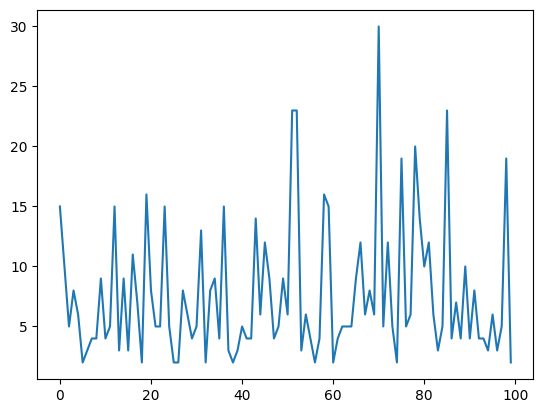

In [ ]:
plt.plot(np.array(env_baseline.length_queue)[:100])

100%|██████████| 25000/25000 [00:07<00:00, 3169.94it/s]


0


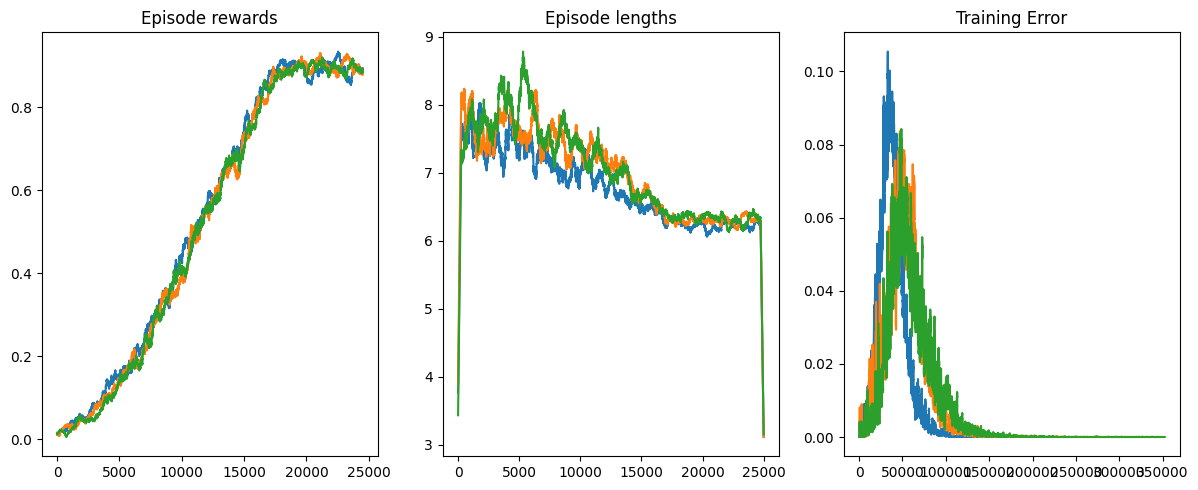

In [ ]:
agent_hf = IRLAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)
env_hf = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
train(env_hf, agent_hf, n_episodes=25000, back_prop=True, human_feedback=False)

plot_stats([(env_baseline, agent_baseline), (env_backprop, agent_backprop), (env_hf, agent_hf)])

In [ ]:
import seaborn as sns

print(agent_hf.q_values)
final_q_values = np.zeros([4,4,4])
for key, val in agent_hf.q_values.items():
    col = key % 4
    row = key // 4

    final_q_values[row, col] = val

fig, ax = plt.subplots(1,5, figsize=(10, 10))

observation, info = env.reset()
img = env.render()

ax[0].imshow(img)

optimal_policy = np.argmax(final_q_values, axis=2)
# ax[0].imshow(optimal_policy, cmap='hot', interpolation='nearest')

for i in range(4):
    for j in range(4):
        if optimal_policy[j, i] == 0:
            dx = -0.5
            dy = 0
        elif optimal_policy[j, i] == 1:
            dx = 0
            dy = 0.5
        elif optimal_policy[j, i] == 2:
            dx = 0.5
            dy = 0
        elif optimal_policy[j, i] == 3:
            dx = 0
            dy = -0.5
        # ax[0].arrow(i, j, dx, dy)
        scale_factor = img.shape[0] / 4
        dx = dx * scale_factor
        dy = dy * scale_factor
        x = (i+.5) * scale_factor
        y = (j+.5) * scale_factor

        if np.all(final_q_values[j, i] == 0):
            continue
        ax[0].annotate("", xy=(x+dx, y+dy), xytext=(x-dx, y-dy),
            arrowprops=dict(arrowstyle="->"))
ax[0].axis('on')

for i in range(4):
    im = ax[i+1].imshow(final_q_values[:, :, i], cmap='hot', interpolation='nearest')
    
    if i == 3:
        cbar = ax[4].figure.colorbar(im, ax = ax[4])

plt.tight_layout()


NameError: name 'agent_hf' is not defined

In [ ]:
import os
import glob

def delete_files_in_directory(directory_path):
   try:
     files = glob.glob(os.path.join(directory_path, '*'))
     for file in files:
       if os.path.isfile(file):
         os.remove(file)
     print("All files deleted successfully.")
   except OSError:
     print("Error occurred while deleting files.")

In [ ]:
import cv2

step_count = 0

env = env_baseline
agent = agent_baseline

# play one episode
obs, info = env.reset()
done = False

img = env.render()
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
delete_files_in_directory("taxi_agent")
cv2.imwrite(f"taxi_agent/0.png", img)

while not done:
    action = agent.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)

    # update the agent
    # agent.update(obs, action, reward, terminated, next_obs)

    # update if the environment is done and the current obs
    done = terminated or truncated
    obs = next_obs

    img = env.render()
    step_count += 1

    # print(step_count)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"taxi_agent/{step_count}.png", img)

!ffmpeg -framerate 4 -i 'taxi_agent/%d.png' -c:v libx264 -preset slow -tune stillimage -crf 24 -vf format=yuv420p -t 10 -movflags +faststart -y output.mp4

from IPython.display import Video

Video("output.mp4")

All files deleted successfully.
ffmpeg version 4.4.2-0ubuntu0.22.04.1+esm3 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.4.0-1ubuntu1~22.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1+esm3 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvi